# Задача Неймана в квадрате

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d, correlate2d
from scipy.ndimage import correlate1d
import matplotlib.cm as cm
from tqdm import tqdm
import solver as s
%matplotlib inline


def draw(phi, im_cmap=cm.gray, contour_cmap='jet', colorbar=True, contours=True, figsize=(8, 12), interpolate=True):
    plt.figure(figsize=figsize)
    interpolation = 'gaussian' if interpolate else 'none'
    im = plt.imshow(phi, interpolation=interpolation, cmap=im_cmap)
    if colorbar:
        CBI = plt.colorbar(im, orientation='horizontal', shrink=.9)
    if contours:
        cnt = plt.contour(phi, 14, cmap=contour_cmap)
        plt.clabel(cnt, inline=1, fontsize=8, fmt='%1.1f')
        plt.colorbar(cnt, shrink=.8, extend='both')
    plt.imshow(phi, interpolation=interpolation, cmap=im_cmap, origin='lower')

$$
\dfrac{u_{m-1,l} -2u_{m,l}+u_{m+1, l}}{h_x^2} + \dfrac{u_{m,l-1} -2u_{m,l}+u_{m, l+1}}{h_y^2} = \varphi_{ml}
$$

Граничное условие на левой(left) стенке

$$
\dfrac{\partial u_{0,l}}{\partial x} = l(y)
$$

Граничное условие на верхней(top) стенке

$$
\dfrac{\partial u_{m,L}}{\partial y} = t(x)
$$

Граничное условие на правой(right) стенке

$$
\dfrac{\partial u_{M,l}}{\partial x} = r(y)
$$

Граничное условие на нижней(bottom) стенке

$$
\dfrac{\partial u_{m,0}}{\partial y} = b(x)
$$

## Разностные схемы на границах

### При hx не равных hy

Разностное уравнение на левой границе

$$
2\dfrac{u_{1,l} - u_{0,l}}{h_x^2} - \dfrac{u_{0,l-1}-2u_{0,l}+u_{0,l+1}}{h_y^2} + \varphi_{0,l} = \dfrac{2}{h_x} l_l
$$

Разностное уравнение на правой границе

$$
2\dfrac{u_{M-1,l} - u_{M,l}}{h_x^2} - \dfrac{u_{M,l-1}-2u_{M,l}+u_{M,l+1}}{h_y^2} + \varphi_{M,l} = \dfrac{2}{h_x} r_l
$$

Разностное уравнение на нижней границе

$$
2\dfrac{u_{m,1} - u_{m,0}}{h_y^2} - \dfrac{u_{m-1,0}-2u_{m,0}+u_{m+1,0}}{h_x^2} + \varphi_{m,0} = \dfrac{2}{h_y} b_m
$$

Разностное уравнение на верхней границе

$$
2\dfrac{u_{m,L-1} - u_{m,L}}{h_y^2} - \dfrac{u_{m-1,L}-2u_{m,L}+u_{m+1,L}}{h_x^2} + \varphi_{m,L} = \dfrac{2}{h_y} t_m
$$

### при hx = hy

$$
u_{n,k} = u_{n+1,k} - hl_k
$$

In [2]:
hx = .01
hy = .01
x = np.arange(0, 1, hx)
y = np.arange(0, 1, hy)
kernel1 = 0.25*np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]])

In [25]:
# массив phi[y, x]
iterations = 10000
phi = 0*np.ones((x.shape[0], y.shape[0]))
l = np.zeros_like(y)
l[:10] = l[:10] + 1 # or 1
r = np.zeros_like(y)
r[-30:-25] = r[-30:-25] + 2 # or 2
t = np.zeros_like(x)
b = np.zeros_like(x)
tmp = phi.copy()
xx, yy = np.meshgrid(x, y)
ro = + 1/((xx-0.43)**2+(yy-0.43)**2 + 0.01) - 1/((xx-0.51)**2+(yy-0.51)**2 + 0.01)
#ro = np.zeros_like(phi)
for _ in tqdm(range(iterations)):
    phi = correlate2d(phi, kernel1, mode='same')
    phi[0, :] = tmp[1, :] - hx*b
    phi[-1, :] = tmp[-2, :] + hx*t
    phi[:, 0] = tmp[:, 1] - hy*l
    phi[:, -1] = tmp[:, -2] + hy*r
    phi[1:-1, 1:-1] = phi[1:-1, 1:-1] - (1/(1/hx**2 + 1/hy**2))*ro[1:-1,1:-1]
#     phi[45:56, 51] = phi[45:56, 50]
#     phi[45:56, 49] = phi[45:56, 50]
#     phi[44,50] = phi[56, 50] = phi[45,50]
    tmp = phi.copy()

100%|██████████| 10000/10000 [00:05<00:00, 1799.06it/s]


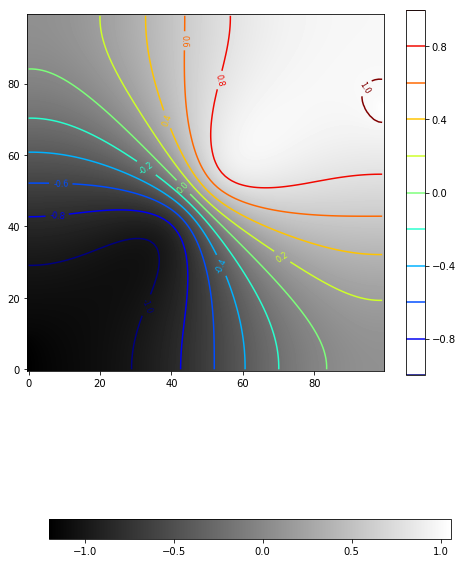

In [26]:
draw(phi)

In [27]:
phix = correlate1d(phi, np.array([-0.5, 0, 0.5])/hx, mode='constant', cval=0.0, axis=1)
phiy = correlate1d(phi, np.array([-0.5, 0, 0.5])/hy, mode='constant', cval=0.0, axis=0)
phix[:, 0] = (phi[:, 1] - phi[:, 0])/hx
phix[:, -1] = (phi[:, -1] - phi[:, -2])/hx
phiy[0, :] = (phi[1, :] - phi[0, :])/hy
phiy[-1, :] = (phi[-1, :] - phi[-2, :])/hy

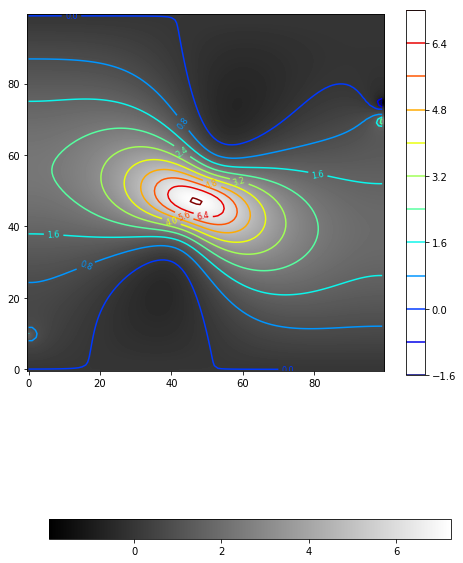

In [28]:
draw(phiy)

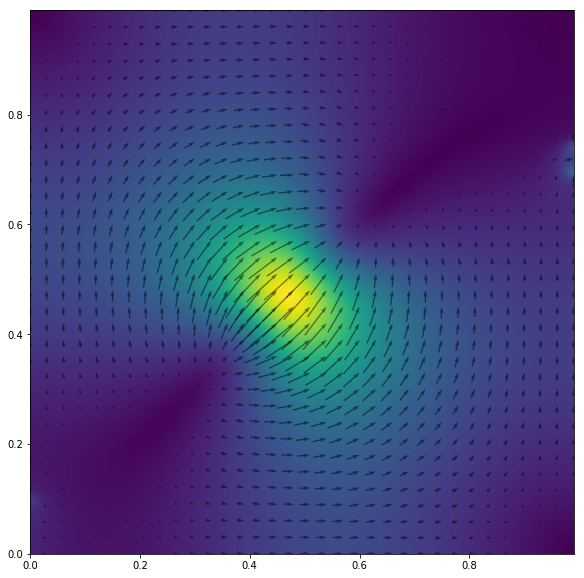

In [29]:
xx, yy = np.meshgrid(x, y)
plt.figure(figsize=(10, 10))
plt.quiver(xx[::3, ::3], yy[::3, ::3], phix[::3, ::3], phiy[::3, ::3], units='x', pivot='tip', edgecolor='k',
          alpha=0.5, cmap='Reds')
plt.imshow(np.sqrt(phix**2+phiy**2), extent=[x.min(), x.max(), y.min(), y.max()], interpolation='gaussian', origin='lower')

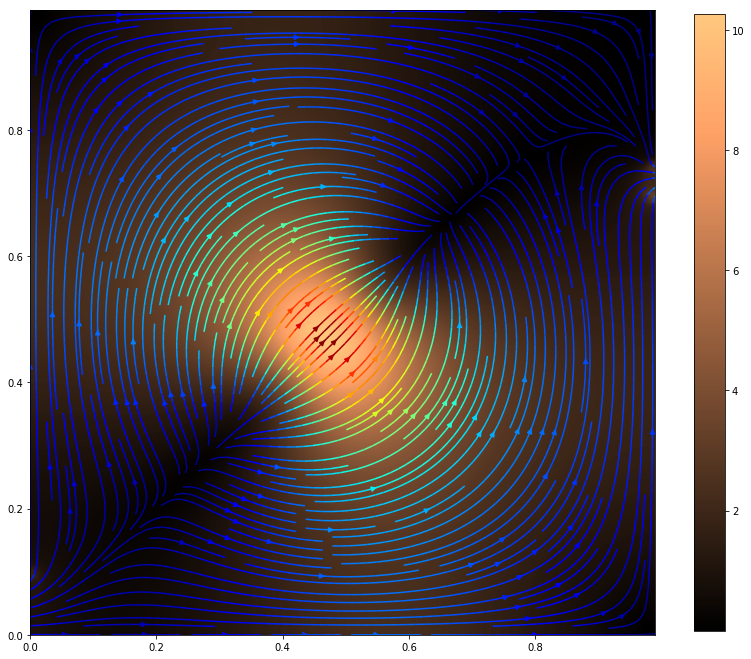

In [30]:
plt.figure(figsize=(14, 14))
color = np.sqrt(phix**2+phiy**2)
plt.streamplot(xx[::, ::], yy[::, ::], phix[::, ::], phiy[::, ::], color=color[::,::],
               density=2.4, cmap=cm.jet)
im = plt.imshow(np.sqrt(phix**2+phiy**2), extent=[x.min(), x.max(), y.min(), y.max()], interpolation='gaussian',cmap=cm.copper,
          origin="lower")
CBI = plt.colorbar(im, orientation='vertical', shrink=.81)

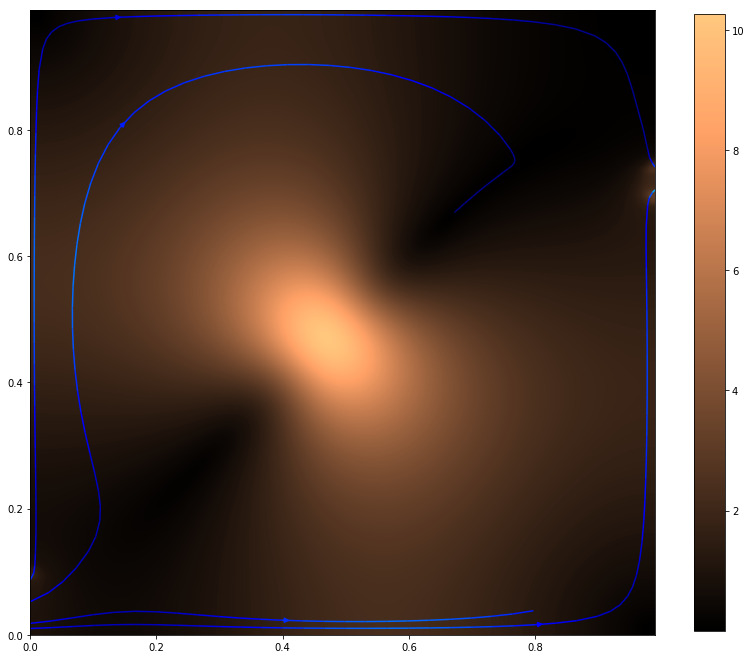

In [31]:
num = 100
start = np.linspace(.01, 0.1, num, endpoint=False).reshape((num, 1))
zeros = np.zeros_like(start)
start = np.concatenate((zeros, start), axis=1)
plt.figure(figsize=(14, 14))
plt.streamplot(x, y, phix[::, ::], phiy[::, ::], color=color[::,::], cmap=cm.jet,
              start_points=start)
im2 = plt.imshow(np.sqrt(phix**2+phiy**2), extent=[x.min(), x.max(), y.min(), y.max()], interpolation='gaussian',cmap=cm.copper,
          origin="lower")
CBI3 = plt.colorbar(im2, orientation='vertical', shrink=.81)